In [62]:
import gpxpy

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import matplotlib.pyplot as plt
import contextily as ctx

from pytz import timezone

from utils import init_postgis, get_location_error, crop_route, get_total_distance

In [63]:
matplotlib.rcParams['timezone'] = 'Asia/Singapore'

In [49]:
input_dir = f"../singapore/benjamin-sheares-bridge"

In [50]:
start_location = (1.309743979078668, 103.89449080743935)
stop_location = (1.309743979078668, 103.89449080743935)

In [51]:
init_postgis('gpx_route', input_dir + '/route.gpx')
init_postgis('glonass', input_dir + '/glonass.gpx')
init_postgis('galileo', input_dir + '/galileo.gpx')
init_postgis('qzss', input_dir + '/qzss.gpx')

In [52]:
glonass_df = get_location_error('glonass')
glonass_df = crop_route(glonass_df, start_location, stop_location, 200)
glonass_df.head(3)

,time,latitude,longitude,distance_to_route,start_distance,stop_distance
0,2024-05-27 06:20:47.641000+08:00,1.309432,103.894385,8.506505,36.485946,36.485946
1,2024-05-27 06:20:48.641000+08:00,1.309440,103.894357,6.876010,36.778371,36.778371
2,2024-05-27 06:20:49.642000+08:00,1.309445,103.894325,5.520462,37.860815,37.860815


In [53]:
galileo_df = get_location_error('galileo')
galileo_df = crop_route(galileo_df, start_location, stop_location, 200)
galileo_df.head(3)

,time,latitude,longitude,distance_to_route,start_distance,stop_distance
0,2024-06-27 22:01:23.692000+08:00,1.309485,103.894632,23.594221,32.646771,32.646771
1,2024-06-27 22:01:24.692000+08:00,1.309478,103.894620,22.436821,32.704171,32.704171
2,2024-06-27 22:01:25.692000+08:00,1.309472,103.894605,20.960953,32.682594,32.682594


In [54]:
qzss_df = get_location_error('qzss')
qzss_df = crop_route(qzss_df, start_location, stop_location, 200)
qzss_df.head(3)

,time,latitude,longitude,distance_to_route,start_distance,stop_distance
0,2024-06-26 22:08:55.439000+08:00,1.309428,103.894555,17.734088,35.626482,35.626482
1,2024-06-26 22:08:56.440000+08:00,1.309423,103.894547,17.293914,35.996657,35.996657
2,2024-06-26 22:08:57.440000+08:00,1.309420,103.894540,16.935502,36.239849,36.239849


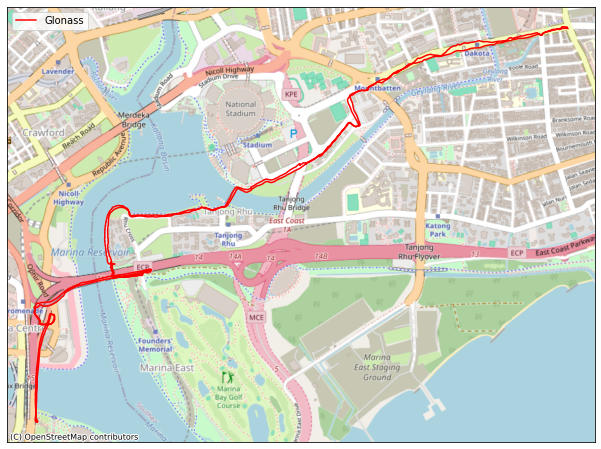

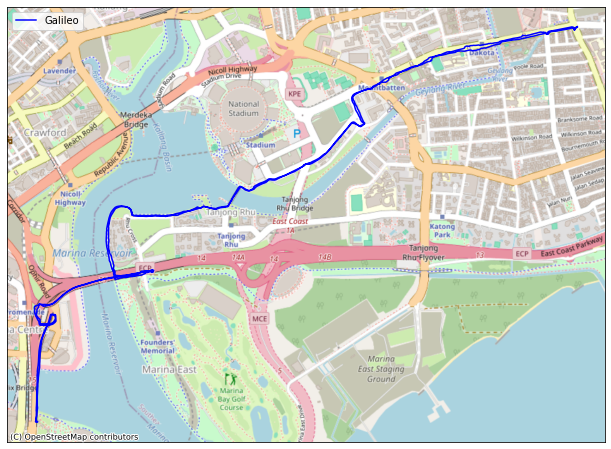

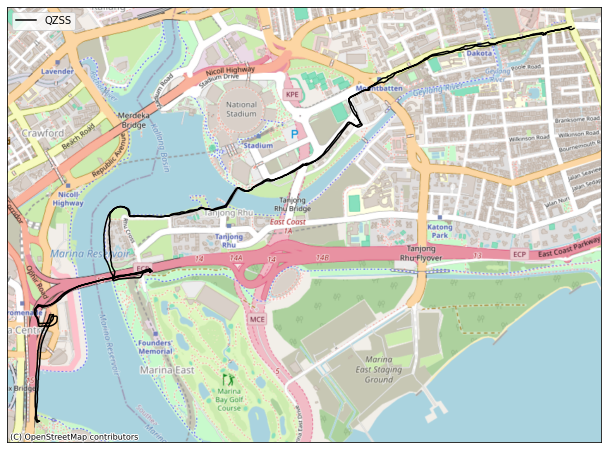

In [55]:
def plot_map(df, color, label):
    plt.figure(figsize=(15, 8))
    plt.plot(df['longitude'], df['latitude'], color=color, label=label)
    ctx.add_basemap(plt.gca(), crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)
    plt.legend()
    plt.xticks([], [])
    plt.yticks([], [])
    plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
    plt.show()
    
plot_map(glonass_df, 'red', 'Glonass')
plot_map(galileo_df, 'blue', 'Galileo')
plot_map(qzss_df, 'black', 'QZSS')

In [56]:
desc_glonass_df = glonass_df['distance_to_route'].describe().to_frame()
desc_glonass_df.columns = ['Glonass']

desc_galileo_df = galileo_df['distance_to_route'].describe().to_frame()
desc_galileo_df.columns = ['Galileo']

desc_qzss_df = qzss_df['distance_to_route'].describe().to_frame()
desc_qzss_df.columns = ['QZSS']

merged_desc = pd.concat([desc_glonass_df, desc_galileo_df, desc_qzss_df], axis=1)
merged_desc.to_csv('/tmp/merged_desc.csv')

print(merged_desc)

           Glonass      Galileo         QZSS
count  4578.000000  4899.000000  4377.000000
mean      8.239243     6.505028     7.952961
std       7.284880     5.341225     7.193113
min       0.002431     0.001662     0.002440
25%       2.870726     2.805011     2.615803
50%       6.703820     5.254399     5.891183
75%      11.454589     8.657075    10.735518
max      46.822614    37.230703    41.164578


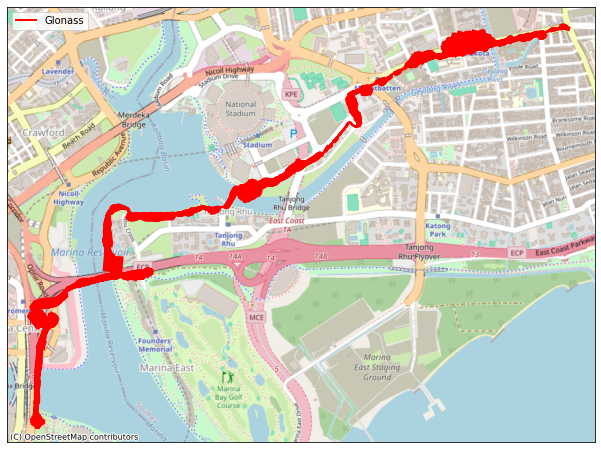

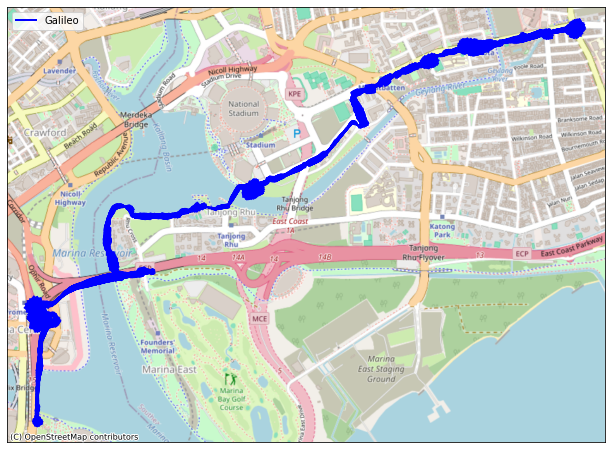

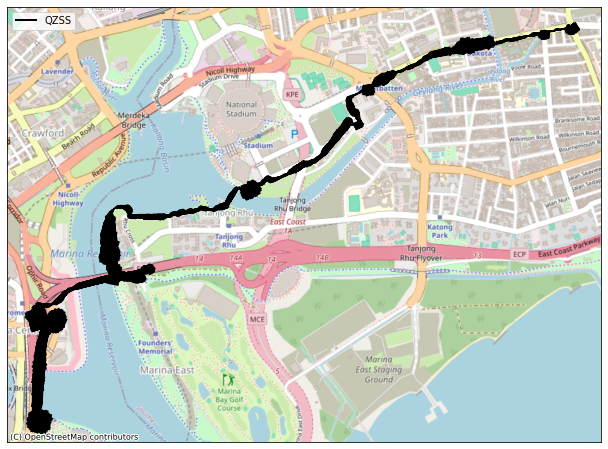

In [57]:
def plot_location_error(df, color, label):
    plt.figure(figsize=(15, 8))
    
    line = None
    for i in range(len(df) - 1):
        line = plt.plot(
            df['longitude'][i:i+2], 
            df['latitude'][i:i+2], 
            linewidth=df['linewidth'][i], 
            color=color, 
        )

    legend = plt.legend(line, [label])
    for legobj in legend.legendHandles:
        legobj.set_linewidth(2.0)
    
    ctx.add_basemap(plt.gca(), crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
    plt.show()

def get_linewidth(df):
    min_range, max_range = 1, 20

    min_val = df['distance_to_route'].min()
    max_val = df['distance_to_route'].max()
    
    return ((df['distance_to_route'] - min_val) / (max_val - min_val)) * (max_range - min_range) + min_range

glonass_df['linewidth'] = get_linewidth(glonass_df)
galileo_df['linewidth'] = get_linewidth(galileo_df)
qzss_df['linewidth'] = get_linewidth(qzss_df)

plot_location_error(glonass_df, 'red', 'Glonass')
plot_location_error(galileo_df, 'blue', 'Galileo')
plot_location_error(qzss_df, 'black', 'QZSS')

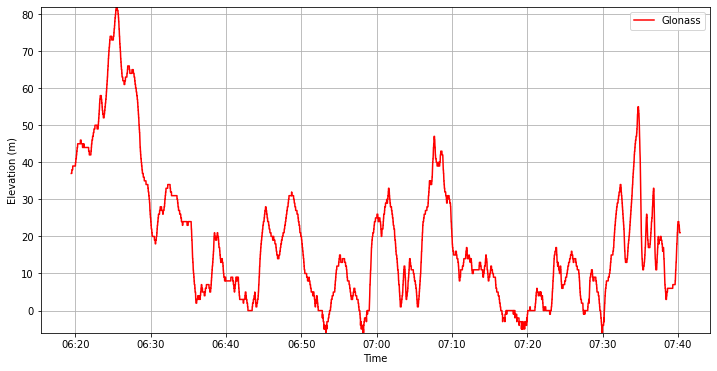

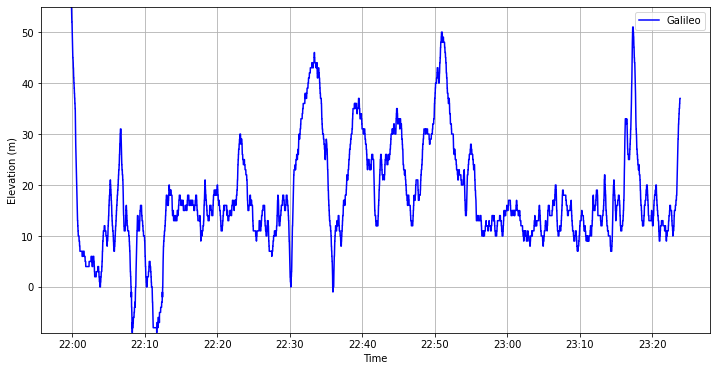

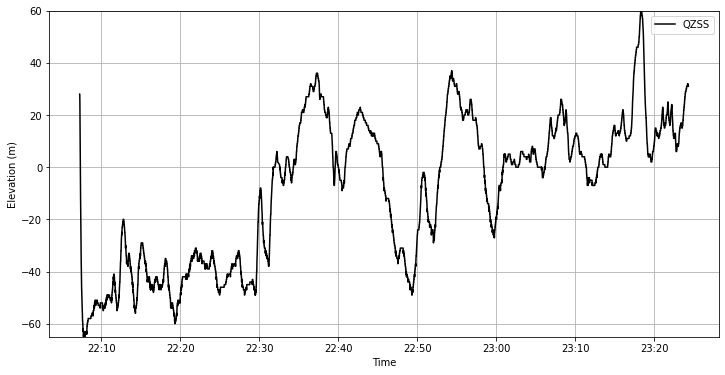

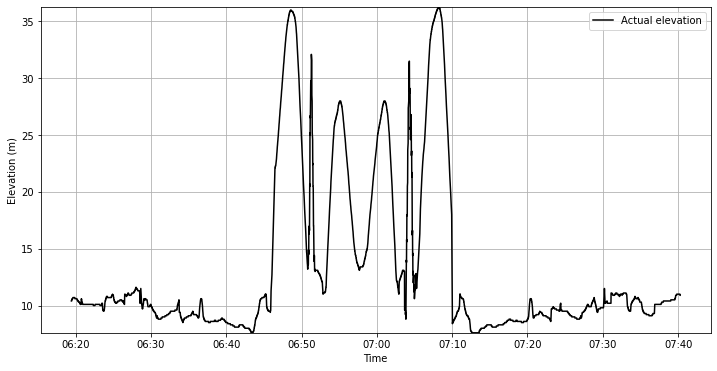

In [84]:
def parse_gpx(filepath):
    gpx_file = open(filepath, 'r')
    gpx = gpxpy.parse(gpx_file)

    data = []
    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                lat, lng = point.latitude, point.longitude,
                time = point.time.astimezone(timezone('Asia/Singapore')) if point.time else None
                data.append({
                  'time': time,
                  'latitude': lat, 
                  'longitude': lng,
                  'elevation': point.elevation,
                })

    df = pd.DataFrame(data)
    return df

def plot_elevation(df, color, label):
    plt.figure(figsize=(12, 6))
    
    plt.plot(df['time'], df['elevation'], color=color, label=label)
    plt.xlabel('Time')
    plt.ylabel('Elevation (m)')
    plt.legend()
    plt.grid(True)
    plt.ylim(min(min(df['elevation']), min(elevation_df['elevation'])), max(max(df['elevation']), max(elevation_df['elevation'])))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.show() 
    
elevation_df = parse_gpx(input_dir + '/elevation.gpx')
glonass_df = parse_gpx(input_dir + '/glonass.gpx')
galileo_df = parse_gpx(input_dir + '/galileo.gpx')
qzss_df = parse_gpx(input_dir + '/qzss.gpx')

plot_elevation(glonass_df, 'red', 'Glonass')
plot_elevation(galileo_df, 'blue', 'Galileo')
plot_elevation(qzss_df, 'black', 'QZSS')
plot_elevation(elevation_df, 'black', 'Actual elevation')